# Visualizing the IEKS
because I really love gifs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tornadox
import parsmooth
from tqdm import trange

import pof
from pof.ivp import logistic, lotkavolterra

In [3]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e2)
ylims = (-3, 3)
#ivp = lotkavolterra()
#ylims = (-1, 9)

In [4]:
dt = 1e-3
order = 2

In [5]:
# Setup the IEKS solver
d, q = ivp.dimension, order
D = d * (q + 1)

iwp = tornadox.iwp.IntegratedWienerTransition(
    num_derivatives=q, wiener_process_dimension=d
)

tfun, Q = pof.solve.get_transition(iwp, dt)
ofun, R = pof.solve.get_observation(ivp, iwp)

times = jnp.arange(ivp.t0, ivp.tmax + dt, dt)
data = jnp.zeros((len(times) - 1, d))
N = len(times)

initial_guess = pof.solve.get_initial_guess(ivp, order)

(-3.0, 3.0)

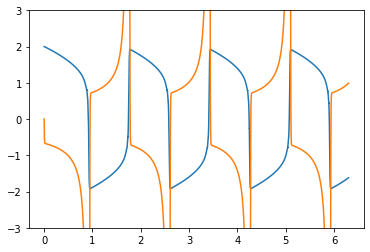

In [6]:
# Standard solve:
_, ekf_states = parsmooth.sequential.ekf(
    initial_guess, data, tfun, Q, ofun, R, None
)
plt.plot(times, ekf_states.mean[:, 0::order+1])
plt.ylim(*ylims)

In [7]:
ieks = jax.jit(parsmooth.parallel.ieks, static_argnums=(2, 4, 7))

In [8]:
# Initial linearization with the initial value
init_lin = parsmooth.utils.MVNormalParameters(
    jnp.repeat(initial_guess.mean.reshape(1, -1), data.shape[0]+1, axis=0),
    jnp.zeros((data.shape[0] + 1, d*(order + 1), d*(order + 1)))
)

(-3.0, 3.0)

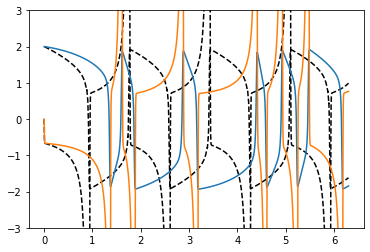

In [9]:
# It does provide a useful output after 100 iterations
n_iter = 100
states = ieks(
    initial_guess, data, tfun, Q, ofun, R, init_lin, n_iter=n_iter
)
plt.plot(times, ekf_states.mean[:, 0::order+1], "--", color="black")
plt.plot(times, states.mean[:, 0::order+1])
plt.ylim(*ylims)

100%|████████████████████████████████████████████████████████████████| 999/999 [01:35<00:00, 10.45it/s]


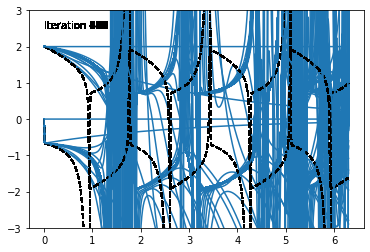

In [15]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

states = init_lin
plt.plot(times, ekf_states.mean[:, 0::order+1], "--", color="black")
plt.plot(times, states.mean[:, 0::order+1], color="C0")
plt.ylim(*ylims)
plt.text(0, ylims[1]-0.5, f"Iteration 0")
camera.snap()
for i in trange(1, 1000):
    linearize_at = states
    states = ieks(
        initial_guess, data, tfun, Q, ofun, R, linearize_at, n_iter=1
    )
    plt.plot(times, ekf_states.mean[:, 0::order+1], "--", color="black")
    plt.plot(times, states.mean[:, 0::order+1], color="C0")
    plt.ylim(*ylims)
    plt.text(0, ylims[1]-0.5, f"Iteration {i}")
    camera.snap()

from IPython.display import HTML
animation = camera.animate()

In [16]:
HTML(animation.to_html5_video())

In [17]:
animation.save('vdp.mp4')